## Data:
`train_features.csv-features for training`
- g-: specifies gene data, [4: 776]
- c-: shows cell viability data [776:]
- cp_type: samples treated with a compound/control vehicle
- cp_dose: treatment dose
- cp_time: duration

`train_targets_scored`
- They are 206 columns with unique values either 1 or 0 in each row
- It also has nothing in common with train_targets_nonscored

In [1]:
import numpy as np
import pandas as pd

train_features, test_features = pd.read_csv('./train_features.csv'), pd.read_csv('./test_features.csv')
train_targets = pd.read_csv('./train_targets_scored.csv')
sub = pd.read_csv('./sample_submission.csv')

## Proprecessing:
1. There are no missing values
2. The categorical variables have been mapped using 1 and -1, since it is more effective than binary in the neural networks.
3. The other features (genes and cells) do not need normalizing since there is obviously some extreme values in them that will cause the model to train better

In [2]:
# The cp_time feature in both train and test are either 24, 48, or 72
print('X_train unqiue cp_time: ', train_features['cp_time'].unique())
print('X_test unqiue cp_time: ', test_features['cp_time'].unique())

# hence it would make sense to normalize the input with regard to mean to generate negative numbers in the column
train_features['cp_time'] = (train_features['cp_time'] - 48) / 48
test_features['cp_time'] = (test_features['cp_time'] - 48) / 48

X_train unqiue cp_time:  [24 72 48]
X_test unqiue cp_time:  [24 72 48]


In [3]:
# Encoding categorical variables

# Dictionaries
cp_type = {'trt_cp': 1, 'ctl_vehicle': -1}
cp_dose = {'D1': 1, 'D2': -1}
# Mapping dictionaries to columns
train_features['cp_type'], test_features['cp_type'] = train_features['cp_type'].map(cp_type), test_features['cp_type'].map(cp_type)
train_features['cp_dose'], test_features['cp_dose'] = train_features['cp_dose'].map(cp_dose), test_features['cp_dose'].map(cp_dose)

In [4]:
# Setting the type of all columns to float
X = train_features.iloc[:,1:].astype('float64')
X_test = test_features.iloc[:,1:].astype('float64')
y = train_targets.iloc[:,1:].astype('float64')

In [5]:
from tensorflow.keras import Model, Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D, ReLU, Dropout, Flatten, Dense, InputLayer, Concatenate, SeparableConv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.initializers import TruncatedNormal, he_uniform, he_normal

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [6]:
# The breakdowns for the dataset

# Training part
cells = X.iloc[:,775:].copy()
genes = X.iloc[:,3:775].copy()
cells_image = cells.values.reshape(cells.shape[0], 10, 10, 1)

# Testing
cells_test = X_test.iloc[:,775: ].copy()
genes_test = X_test.iloc[:,3:775].copy()
cells_image_test = cells_test.values.reshape(cells_test.shape[0], 10, 10, 1)

In [7]:
# Inputs to the NN models 
all_data = Input(shape=(X.shape[1]), name='All')
cells_input = Input(shape=(cells.shape[1]), name='Cells')
genes_input = Input(shape=(genes.shape[1]), name='Genes')
cell_image_input = Input(shape=(10,10,1), name='Cells_image')

In [ ]:
# Ensemble method

def linear_classifier(x, std):
    out = Dense(206, TruncatedNormal(0, std, 11))(x)
    out = BatchNormalization()(Dense(206, TruncatedNormal(0, std+1e-6, 11))(x))
    out = ReLU(threshold=1e-6)(out)
    out = Dense(206, activation='softmax', TruncatedNormal(0, std-1e-6, 11))(out)
    
    return out


# 5 stop ensembling:

e1 = linear_classifier(all_data, 0.005)
e2 = linear_classifier(e1, 5e-3)
e3 = lienar_clas


In [50]:
def FeatureExtracter(std=1, units=32, seed=11):
    out = Dense(units, kernel_initializer=TruncatedNormal(0, std, seed=seed), name='m1'+str(std))(all_data)
    out = BatchNormalization(name=f'b1{std}')(Dense(units, kernel_initializer=TruncatedNormal(0, std, seed=seed), name=f'm2{std}')(out))
    out = Dense(units, kernel_initializer=TruncatedNormal(0, std, seed=seed), name='STD'+str(std))(out)
    
    return out

def inception_module(x, units=32, seed=13, std=1):
    l1 = Dense(units=units, kernel_initializer=TruncatedNormal(0, std, seed=seed), name=f'1{std}')(x)

    l2 = Dense(units=units, activation='tanh', kernel_initializer=TruncatedNormal(0, std * 2, seed=seed), name=f'21{std}')(x)
    l2 = Dense(units=units, kernel_initializer=TruncatedNormal(0, std * 2 + 0.1, seed=seed), name=f'22{std}')(l2)

    l3 = Dense(units=units, activation='tanh', kernel_initializer=TruncatedNormal(0, std * 3, seed=seed), name=f'31{std}')(x)
    l3 = Dense(units=units, activation='sigmoid', kernel_initializer=TruncatedNormal(0, std * 3 + 0.1, seed=seed), name=f'32{std}')(l3)
    l3 = Dense(units=units, kernel_initializer=TruncatedNormal(0, std * 3 + 0.5, seed=seed), name=f'33{std}')(l3)

    l4 = Dense(units=units, activation='tanh', kernel_initializer=TruncatedNormal(0, std * 4, seed=seed), name=f'41{std}')(x)
    l4 = Dense(units=units, activation='sigmoid', kernel_initializer=TruncatedNormal(0, std * 4 + 0.01, seed=seed), name=f'42{std}')(l4)
    l4 = Dense(units=units, activation='tanh', kernel_initializer=TruncatedNormal(0, std * 4 + 0.05, seed=seed), name=f'43{std}')(l4)
    l4 = Dense(units=units, kernel_initializer=TruncatedNormal(0, std * 4 + 0.1, seed=seed), name=f'44{std}')(l4)

    return Concatenate(name=f'c{seed}')([l1, l2, l3, l4])

def inception_prediction(x, seed):
    out = Dense(y.shape[1], activation='relu')(x)
    out = BatchNormalization(name=f'bn01{seed}')(Dense(y.shape[1], activation='relu')(out))
    out = BatchNormalization(name=f'bn02{seed}')(Dense(y.shape[1], activation='relu')(out))
    
    return Dense(y.shape[1], activation='softmax')(out)

In [51]:
# Getting all the different FeatueExtracter blocks
feature_extractors = [FeatureExtracter(10 ** (3 - i),seed=10 * i + 1) for i in range(8)]

# Combination of different feature Extractors and predictions

# Phase1: take 4 set of 4 out of 8 with diverse features and one full concatenation
full_concat1 = Concatenate(name='full_con_1')(feature_extractors)
first4 = Concatenate(name='first4')(feature_extractors[0:4])
last4 = Concatenate(name='last4')(feature_extractors[5:8])
comb4_1 = Concatenate(name='comb4_1')([feature_extractors[0], feature_extractors[2], feature_extractors[4], feature_extractors[6]])
comb4_2 = Concatenate(name='comb4_2')([feature_extractors[1], feature_extractors[3], feature_extractors[5], feature_extractors[7]])

# The first prediction will be based on the first round of feature extraction
pred1 = Dense(y.shape[1], activation='relu')(full_concat1)
pred1 = Dense(y.shape[1], activation='softmax', name='pred1')(pred1)

# Phase2: Using inception modules, further go through the feature extraction
inceptions = [inception_module(inp, std=10 ** (2 - index), seed=5 * index) for index, inp in enumerate([first4, last4, comb4_1, comb4_2])]

# The second prediction will be made using the second phase of feature extraction
full_concat2 = Concatenate(name='full_con_2')(inceptions)
pred2 = Dense(y.shape[1], activation='relu')(full_concat2)
pred2 = Dense(y.shape[1], activation='softmax', name='pred2')(pred2)

# In this phase each of the Features extracted will go through predictions
inception_predictions = Concatenate(name='preds_combo')([inception_prediction(x, 8 * index + 1) for index, x in enumerate(inceptions)] + [pred1, pred2])

output = BatchNormalization()(Dense(2048, kernel_initializer=TruncatedNormal(0, 2, seed=1))(inception_predictions))
output = BatchNormalization()(Dense(512, kernel_initializer=TruncatedNormal(0, 1.5, seed=11))(output))
output = BatchNormalization()(Dense(y.shape[1], kernel_initializer=TruncatedNormal(0, 0.5, seed=111))(output))
output = Dense(y.shape[1], activation='softmax', kernel_initializer=TruncatedNormal(0, 0.005, seed=111))(output)

model = Model(inputs=[all_data], outputs=[output])

In [38]:

model.summary()

                    
                                                                 STD10[0][0]                      
                                                                 STD0.1[0][0]                     
                                                                 STD0.001[0][0]                   
__________________________________________________________________________________________________
comb4_2 (Concatenate)           (None, 128)          0           STD100[0][0]                     
                                                                 STD1[0][0]                       
                                                                 STD0.01[0][0]                    
                                                                 STD0.0001[0][0]                  
__________________________________________________________________________________________________
41100 (Dense)                   (None, 32)           4128        first4[0][0]           

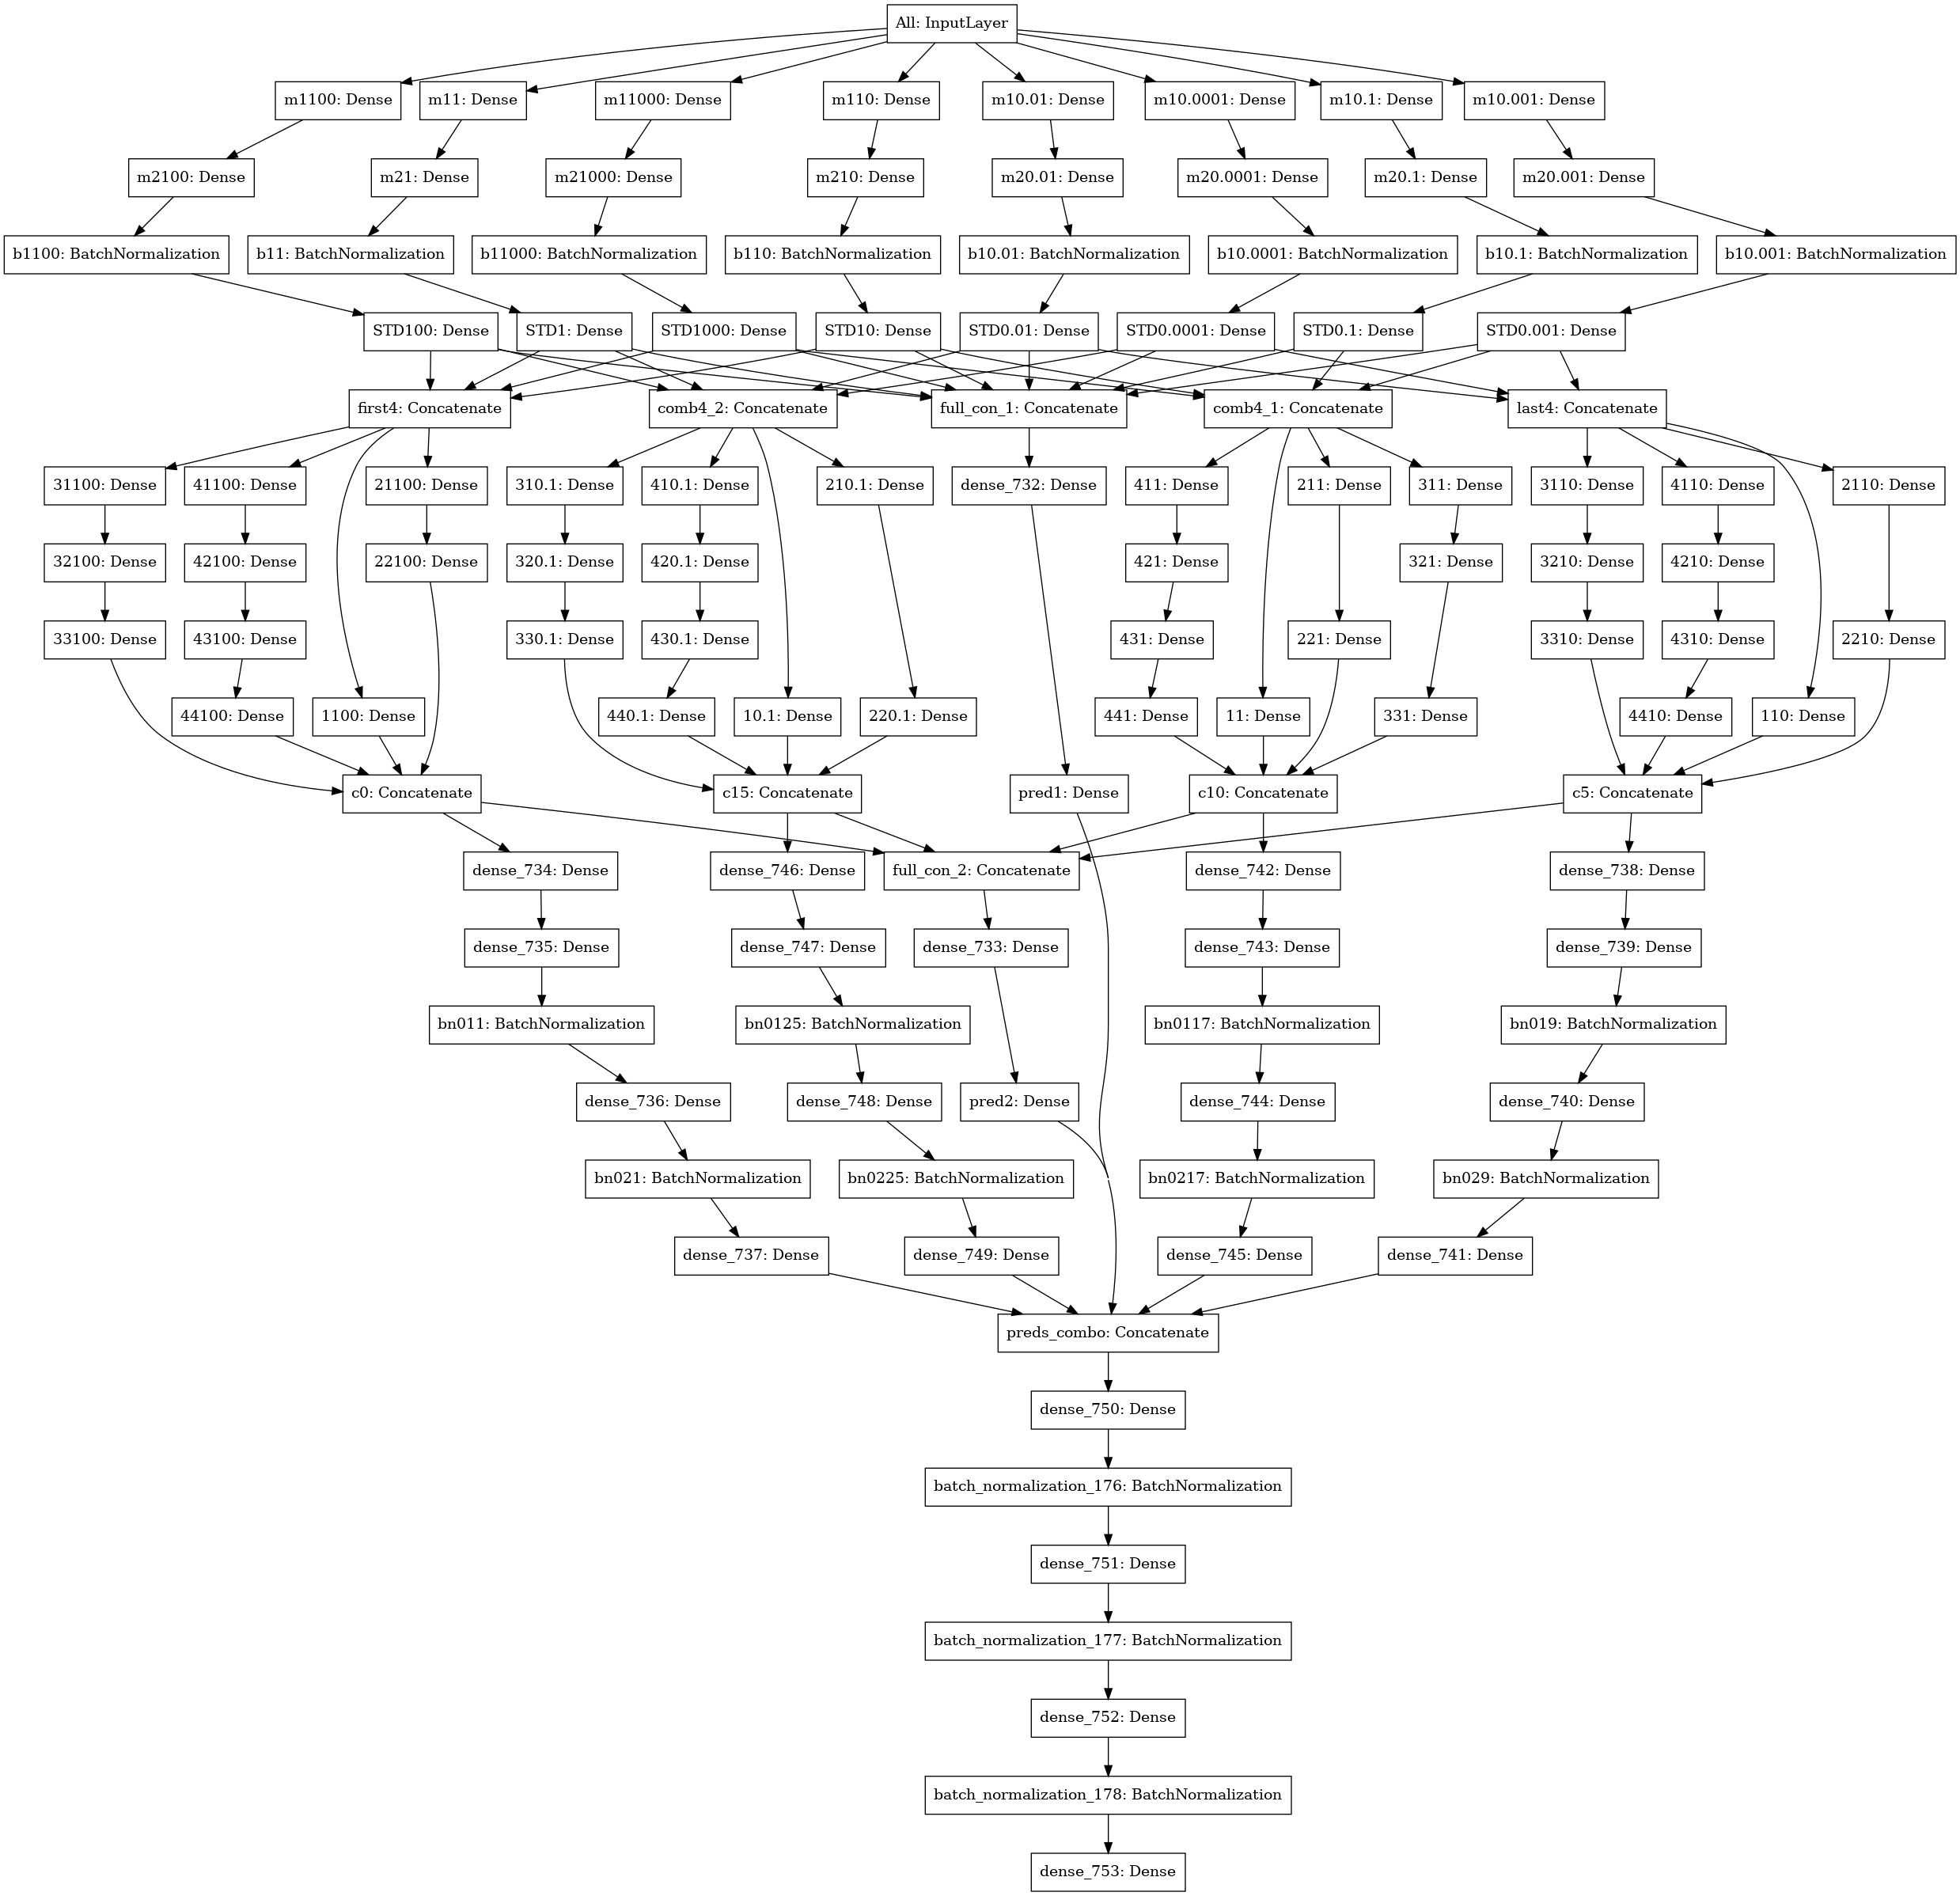

In [52]:
plot_model(model)

Modeling Ideas
- Using CNNs on the cell columns: Make 10x10 dataframes and then feed it from a different part of the model and then combine the results.
- Partitioning input: In general it is possible to break data into parts and process it differently and then aggregiate the results.
- Instead of treating the problem as multi-label classification, get the index in the dataframe row.

In [48]:
model.compile(Adam(0.0015), loss=CategoricalCrossentropy())
model.fit(X,y,epochs=10, verbose=1)

Epoch 1/10


ValueError: in user code:

    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:747 train_step
        y_pred = self(x, training=True)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/functional.py:385 call
        return self._run_internal_graph(
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/input_spec.py:212 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer m10.1 is incompatible with the layer: expected axis -1 of input shape to have value 874 but received input with shape [None, 875]


In [57]:
# Basic NN model (using the whole dataset at once)

def linear_network(input_data):
    """ 
        A block of Dense networks that try to find features with in the data. 
        
        input_data: data inputed into the linear network
        retuns: the output after going through the networks
    """
    
    output = BatchNormalization()(Dense(16)(input_data))
    output = BatchNormalization()(Dense(64)(output))
    output = BatchNormalization()(Dense(256)(output))
    output = Dense(1024)(output)
    
    return output

def NN01(input_data, num_sections=3):
    """
        This model uses sub-models (custom layers) to construct a model and 
        it uses the output of those sub-models to make a prediction.
        
        input_data: the all features input
        num_sections: Number of sections that should be added to the model
        
        returns: the output of the given model
    """
    # Getting the sub-sections of the model
    pre_prediction = Concatenate()([linear_network(input_data) for i in range(0, num_sections)])
    
    # Classification usign fully connected layers:
    # Instead of using batchNormalization, I am using Dropout because extreme numbers are welcomed!!
    fl = Dense(100, activation='relu')(pre_prediction)
    fl = Dropout(0.5)(fl)
    fl = Dense(100, activation='relu')(fl)
    fl = Dropout(0.3)(fl)
    fl = Dense(100, activation='relu')(fl)
    fl = Dropout(0.1)(fl)
    
    output = Dense(y.shape[1] - 1, activation='softmax', name='output')(fl)
    
    
    return output

In [58]:
NN01(all_data, 10)

<tf.Tensor 'output/Softmax:0' shape=(None, 205) dtype=float32>

In [71]:
X_test['sig_id']

0       id_0004d9e33
1       id_001897cda
2       id_002429b5b
3       id_00276f245
4       id_0027f1083
            ...     
3977    id_ff7004b87
3978    id_ff925dd0d
3979    id_ffb710450
3980    id_ffbb869f2
3981    id_ffd5800b6
Name: sig_id, Length: 3982, dtype: object

### Hyperparameter Tuning:
- The number of sub-models in NN01 is a hyperparameter that we should try to find the most optimal value for it. This could be done by training and evaluating multiple Models with different number of sub-models.

In [67]:
X_train.shape[0] / 128

186.046875

In [83]:
X_train.iloc[:,1:]

,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,1,-0.5,1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,1,0.5,1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,1,0.0,1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,1,0.0,1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,1,0.5,-1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,1,-0.5,-1,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,0.5773,...,0.1969,0.0262,-0.8121,0.3434,0.5372,-0.3246,0.0631,0.9171,0.5258,0.4680
23810,1,-0.5,-1,-1.3260,0.3478,-0.3743,0.9905,-0.7178,0.6621,-0.2252,...,0.4286,0.4426,0.0423,-0.3195,-0.8086,-0.9798,-0.2084,-0.1224,-0.2715,0.3689
23811,-1,0.0,-1,0.3942,0.3756,0.3109,-0.7389,0.5505,-0.0159,-0.2541,...,0.5409,0.3755,0.7343,0.2807,0.4116,0.6422,0.2256,0.7592,0.6656,0.3808
23812,1,-0.5,1,0.6660,0.2324,0.4392,0.2044,0.8531,-0.0343,0.0323,...,-0.1105,0.4258,-0.2012,0.1506,1.5230,0.7101,0.1732,0.7015,-0.6290,0.0740


In [144]:
NUM_SECTIONS = [3, 5, 10, 15, 20, 25]

histories = {}

for num_section in NUM_SECTIONS:
    # Defining the model with respect to number of sub-sections in model
    model_name = 'NN01-' + str(num_section) # Model's name
    model = Model(inputs=[all_data], outputs=[NN01(all_data, 25)], name=model_name) # Model itself
    model.compile(optimizer=Adam(0.0015), loss=CategoricalCrossentropy())
    print(model_name)
    histories[model_name] = model.fit(
        x=X, y=y, epochs=800, batch_size=128, validation_split=0.2,
        callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.96, min_delta=1e-4, patience=10, min_lr=1e-6)]
    )
    
    output = pd.DataFrame({'Id': x_test['sig_id'],
                      'SalePrice': pd.DataFrame(model.predict(X_test)[0])[0]})
    output.to_csv(f'/kaggle/working/NN01_{num_section}.csv', index=False)

NN01-3


KeyboardInterrupt: 

In [65]:
model = Model(inputs=[all_data], outputs=[NN01(all_data, 25)], name='NN01')
model.summary()

Model: "NN01"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
All (InputLayer)                [(None, 875)]        0                                            
__________________________________________________________________________________________________
dense_537 (Dense)               (None, 16)           14016       All[0][0]                        
__________________________________________________________________________________________________
dense_541 (Dense)               (None, 16)           14016       All[0][0]                        
__________________________________________________________________________________________________
dense_545 (Dense)               (None, 16)           14016       All[0][0]                        
_______________________________________________________________________________________________

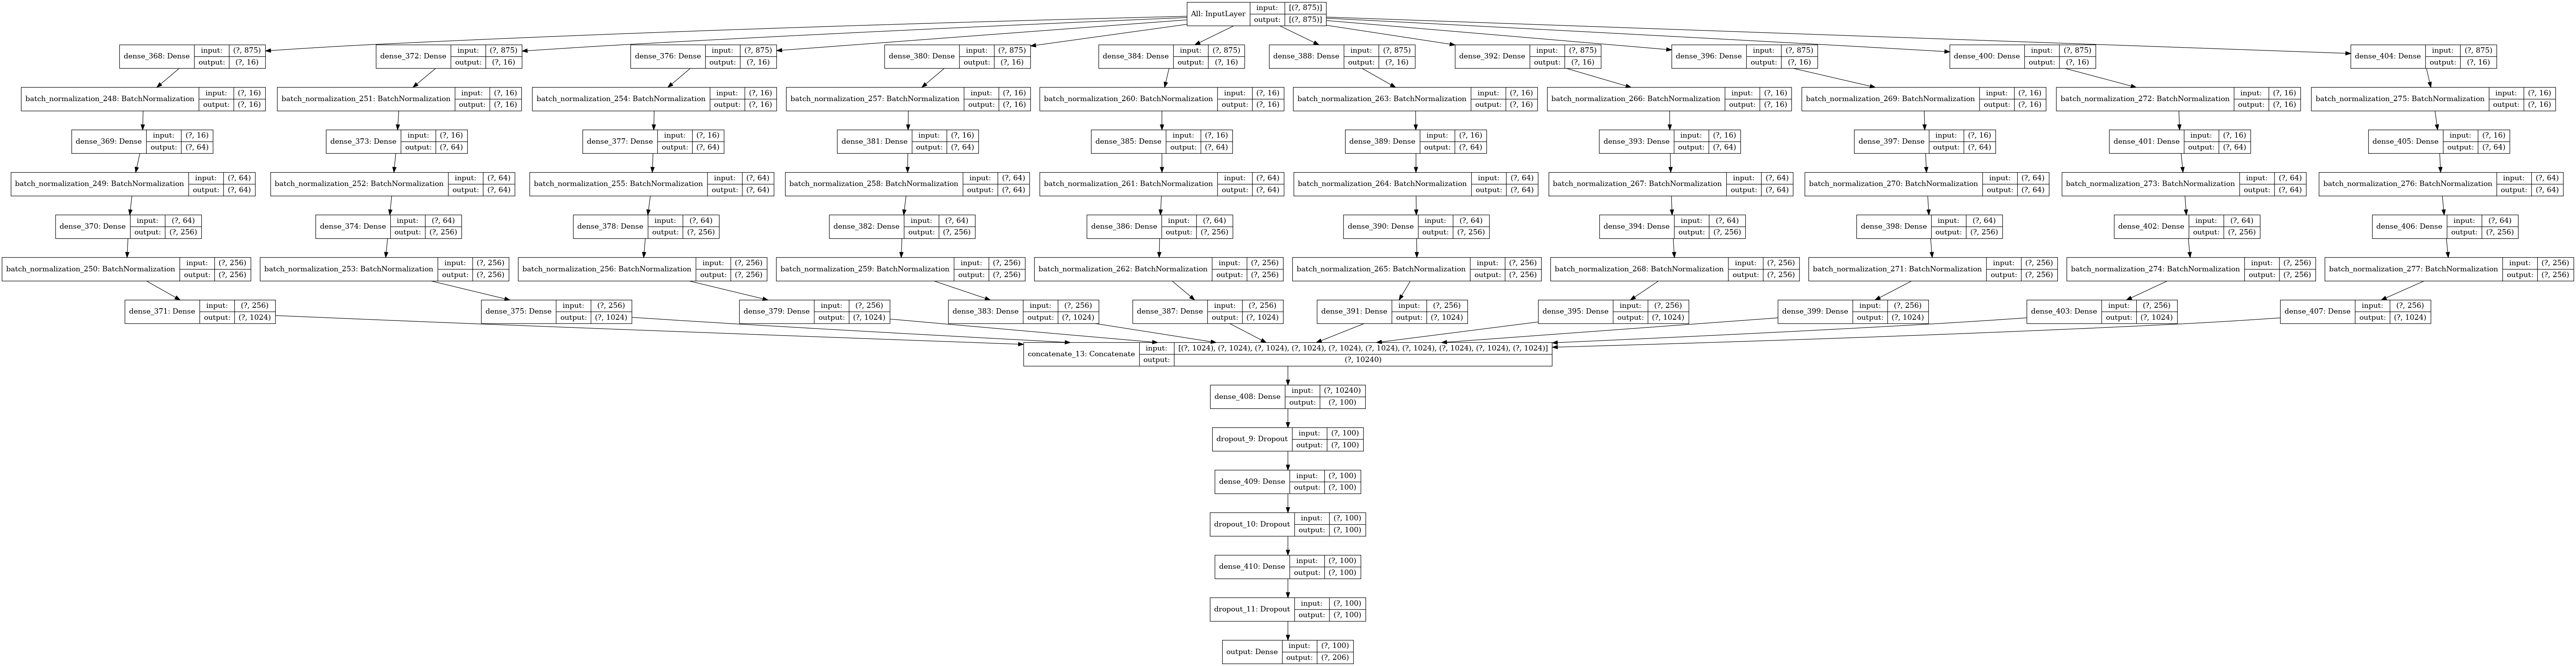

In [62]:
plot_model(model, './img/NN01.png', show_shapes=True)

In [57]:
# Some convolutional structures used with in the CNN
# The inception functions are inspired by the inception modules used in the inception model

def inception01(input_data, mean=0, std=1):
    # Layers 1:
    layer11 = SeparableConv2D(256, (1,1), padding='same',
            kernel_initializer=TruncatedNormal(mean=mean * 0.5, stddev=std * 0.5, seed=14)
            )(input_data)
    
    # Layers 2:
    layer21 =  SeparableConv2D(512, (3,3),padding='same',
            kernel_initializer=TruncatedNormal(mean=mean + 0.5, stddev=std * 1.5, seed=15)
            )(input_data)
    layer22 =  SeparableConv2D(256, (1,1),padding='same',
            kernel_initializer=TruncatedNormal(mean=mean + 0.5, stddev=std * 1.5, seed=15)
            )(layer21)
    
    # Layers 3:
    layer31 =  SeparableConv2D(512, (1,1),padding='same',
            kernel_initializer=TruncatedNormal(mean=mean + 0.5, stddev=std * 2.5 + 0.1,seed=16)
            )(input_data)
    layer32 =  SeparableConv2D(256, (3,3),padding='same',
            kernel_initializer=TruncatedNormal(mean=mean + 0.5, stddev=std * 2.5 + 0.1, seed=16)
            )(layer31)
    
    # Layers 4:
    layer41 =  SeparableConv2D(512, (1,1),padding='same',
            kernel_initializer=TruncatedNormal(mean=mean - 0.5, stddev=std + 0.6,seed=17)
            )(input_data)
    layer42 =  SeparableConv2D(256, (5,5),padding='same',
            kernel_initializer=TruncatedNormal(mean=mean - 0.5, stddev=std +0.6,seed=17)
            )(layer41)

    return Concatenate()([layer11, layer22, layer32, layer42])

def inception02(input_data, mean=0, std=1):
    # Layers 1:
    layer11 = SeparableConv2D(128, (1,1),
            kernel_initializer=TruncatedNormal(mean=mean * 0.5, stddev=std * 0.5, seed=14)
            )(input_data)
    
    # Layers 2:
    layer21 =  SeparableConv2D(512, (1,1), activation='relu',
            kernel_initializer=TruncatedNormal(mean=mean + 0.5, stddev=std * 1.5, seed=15)
            )(input_data)
    layer22 =  SeparableConv2D(128, (2, 2),
            kernel_initializer=TruncatedNormal(mean=mean + 0.5, stddev=std * 1.5, seed=15)
            )(layer21)
    
    # Layers 3:
    layer31 =  SeparableConv2D(512, (1,1),activation='relu',
            kernel_initializer=TruncatedNormal(mean=mean + 0.5, stddev=std * 2.5 + 0.1,seed=16)
            )(input_data)
    layer32 =  SeparableConv2D(256, (1, 1),activation='relu',
            kernel_initializer=TruncatedNormal(mean=mean + 0.5, stddev=std * 2.5 + 0.1, seed=16)
            )(layer31)
    layer32 =  SeparableConv2D(128, (3,3),
            kernel_initializer=TruncatedNormal(mean=mean + 0.5, stddev=std * 2.5 + 0.1, seed=16)
            )(layer32)
    
    # Layers 4:
    layer41 =  SeparableConv2D(512, (1,1),activation='relu',
            kernel_initializer=TruncatedNormal(mean=mean - 0.5, stddev=std + 0.6,seed=17)
            )(input_data)
    layer42 =  SeparableConv2D(256, (1,1),activation='relu',
            kernel_initializer=TruncatedNormal(mean=mean - 0.5, stddev=std +0.6,seed=17)
            )(layer41)
    layer42 =  SeparableConv2D(256, (1,1),activation='relu',
            kernel_initializer=TruncatedNormal(mean=mean - 0.5, stddev=std +0.6,seed=17)
            )(layer41)
    layer42 =  SeparableConv2D(128, (5,5),
            kernel_initializer=TruncatedNormal(mean=mean - 0.5, stddev=std +0.6,seed=17)
            )(layer41)

    return Concatenate()(
        [Flatten()(layer11), 
         Flatten()(layer22), 
         Flatten()(layer32), 
         Flatten()(layer42)]
    )

In [51]:
# CNN model:

def CNN_model_01(input_data):
    """ Simple """
    conv1 = SeparableConv2D(256, (1,1), 
        kernel_initializer=TruncatedNormal(mean=0, stddev=0.05,seed=117)
    )(input_data)
    conv1 = BatchNormalization()(SeparableConv2D(256, (1, 1),
        kernel_initializer=TruncatedNormal(mean=0, stddev=0.05,seed=118)
    )(conv1))
    conv1 = SeparableConv2D(512, (3,3),
        kernel_initializer=TruncatedNormal(mean=0, stddev=0.05,seed=117), padding='same'
    )(conv1)
    
    fl1 = BatchNormalization()(Dense(1000, activation='relu')(Flatten()(conv1)))
    fl1 = Dense(1000, activation='relu')(Flatten()(fl1))
    
    conv2 = SeparableConv2D(256, (1,1), 
        kernel_initializer=TruncatedNormal(mean=10, stddev=5,seed=7)
    )(input_data)
    conv2 = BatchNormalization()(SeparableConv2D(256, (1, 1),
        kernel_initializer=TruncatedNormal(mean=10, stddev=5,seed=8)
    )(conv2))
    conv2 = SeparableConv2D(512, (3,3),
        kernel_initializer=TruncatedNormal(mean=10, stddev=5,seed=7), padding='same'
    )(conv2)
    
    fl2 = BatchNormalization()(Dense(1000, activation='relu')(Flatten()(conv2)))
    fl2 = Dense(1000, activation='relu')(Flatten()(fl2))
    
    conv3 = SeparableConv2D(256, (1,1), 
        kernel_initializer=TruncatedNormal(mean=-10, stddev=5,seed=7)
    )(input_data)
    conv3 = BatchNormalization()(SeparableConv2D(256, (1, 1),
        kernel_initializer=TruncatedNormal(mean=-10, stddev=5,seed=8)
    )(conv3))
    conv3 = SeparableConv2D(512, (3,3),
        kernel_initializer=TruncatedNormal(mean=-10, stddev=5,seed=7), padding='same'
    )(conv3)
    
    fl3 = Dense(1000, activation='relu')(Flatten()(conv3))
    fl3 = Dense(1000, activation='relu')(Flatten()(fl3))
    
    return Concatenate()([fl1, fl2, fl3])

In [52]:
CNN_model_01(cell_image_input)

<tf.Tensor 'concatenate/concat:0' shape=(None, 3000) dtype=float32>